# Simple Convolutional Autoencoder (simple dots)

## Imports and definitions

### Model Class and Loss Function Definitions

In [27]:
# %load sconce/models/basic_convolutional_autoencoder.py
from torch import nn
from torch.nn import functional as F
from sconce.models.layers import Convolution2dLayer, Deconvolution2dLayer


class BasicConvolutionalAutoencoder(nn.Module):
    """
    A basic 2D image autoencoder built up of convolutional layers, three each in the encoder and the decoder.

    Loss:
        This model uses binary cross-entropy for the loss.

    Metrics:
        None

    Arguments:
        image_channels (int): the number of channels in the input images.
        conv_channels (list of int): a list of length three of integers describing the number of channels in each of the
            three convolutional layers.
    """
    def __init__(self, image_channels, conv_channels):
        super().__init__()
        self.conv1 = Convolution2dLayer(
                in_channels=image_channels,
                out_channels=conv_channels[0])

        self.conv2 = Convolution2dLayer(
                in_channels=conv_channels[0],
                out_channels=conv_channels[1])

        self.conv3 = Convolution2dLayer(
                in_channels=conv_channels[1],
                out_channels=conv_channels[2],
                padding=2)

        self.deconv1 = Deconvolution2dLayer(
                in_channels=conv_channels[2],
                out_channels=conv_channels[1],
                padding=2,
                output_padding=0)

        self.deconv2 = Deconvolution2dLayer(
                in_channels=conv_channels[1],
                out_channels=conv_channels[0])

        self.deconv3 = Deconvolution2dLayer(
                in_channels=conv_channels[0],
                out_channels=image_channels,
                preactivate=True)


    def encode(self, x_in, **kwargs):
        x = self.conv1(x_in)
        x = self.conv2(x)
        x_latent = self.conv3(x)
        return x_latent

    def decode(self, x_latent):
        x = self.deconv1(x_latent)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x_out = nn.Sigmoid()(x)
        return x_out

    def forward(self, inputs, **kwargs):
        x_latent = self.encode(inputs)
        x_out = self.decode(x_latent)
        return {'outputs': x_out}

    def calculate_loss(self, inputs, outputs, **kwargs):
        reconstruction_loss = F.binary_cross_entropy(outputs,
                inputs.view_as(outputs))
        return {'loss': reconstruction_loss}


## DataGenerators

In [28]:
from sconce.data_generators import ImageDataGenerator
from sconce.datasets import SimpleDots
import numpy as np
from torch.utils import data

kwargs = {
    'batch_size': 100,
    'num_workers': 7,
    'pin_memory': True,
    'shuffle': True
}

full_dataset = SimpleDots(image_size=(28, 28))

# split the dataset into a training subset and test subset
np.random.seed(0)
num_samples = len(full_dataset)
indices = np.arange(0, num_samples)
np.random.shuffle(indices)
training_dataset = data.dataset.Subset(full_dataset, indices=indices[:int(num_samples*0.8)])
test_dataset = data.dataset.Subset(full_dataset, indices=indices[int(num_samples*0.8):])

training_generator = ImageDataGenerator.from_dataset(training_dataset, **kwargs)
test_generator = ImageDataGenerator.from_dataset(test_dataset, **kwargs)

In [30]:
training_generator.real_dataset

SimpleDots Dataset
    Size of images: (28, 28)
    Radius of circle: 4
    Number of images: 400

## Trainer

In [11]:
import torch
from torch import optim
from sconce.trainers import AutoencoderTrainer

def get_trainer(conv_channels=[2, 2, 2], momentum=0.9, weight_decay=1e-4):
    model = BasicConvolutionalAutoencoder(image_channels=1, conv_channels=conv_channels)
    
    if torch.cuda.is_available():
        model.cuda()
        training_generator.cuda()
        test_generator.cuda()
        
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

    trainer = AutoencoderTrainer(model=model, optimizer=optimizer,
        training_data_generator=training_generator,
        test_data_generator=test_generator)
    return trainer

## Results

### Constricted Bottleneck

In [18]:
trainer = get_trainer(conv_channels=[4, 8, 2])
trainer.num_trainable_parameters

1017

40/40 [==============================] - 2s 42ms/step - loss: 1.0917


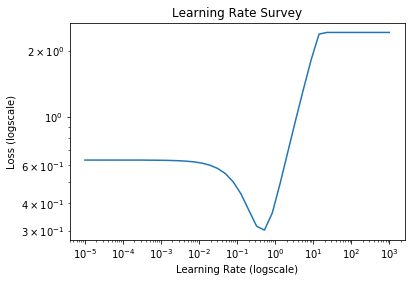

In [19]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=10,
    min_learning_rate=1e-5,
    max_learning_rate=1e3,
    stop_factor=10)
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

In [20]:
from sconce.rate_controllers import TriangleRateController
rate_controller = TriangleRateController(max_learning_rate=0.2, min_learning_rate=0.01)
trainer.train(num_epochs=100, rate_controller=rate_controller)

400/400 [==============================] - 29s 73ms/step - loss: 0.1282 - val_loss: 0.1301


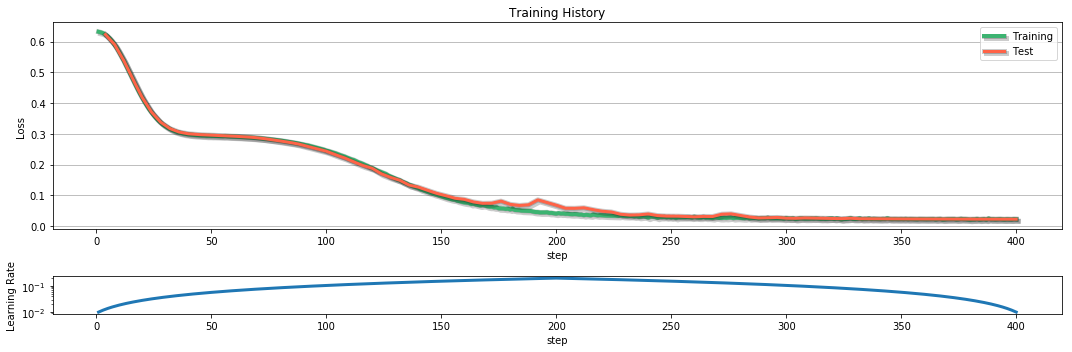

In [21]:
trainer.monitor.dataframe_monitor.plot(smooth_window=1, skip_first=0);

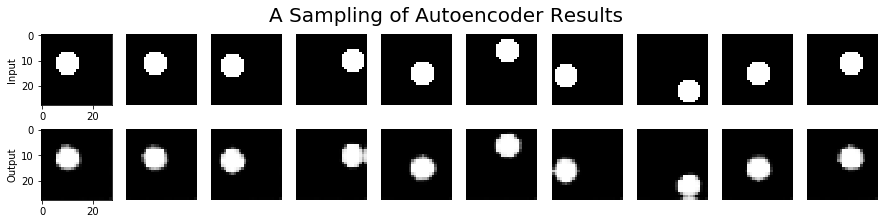

In [22]:
trainer.plot_input_output_pairs();

In [23]:
test_monitor = trainer.test()
test_loss = test_monitor.dataframe_monitor.df['test_loss'].mean()
print(f'Final Test Loss: {test_loss: 0.3e}')

4/4 [==============================] - 0s 120ms/step - loss: 0.0221
Final Test Loss:  2.208e-02


### Relaxed Bottleneck

In [24]:
def train_convolutional_ae(conv_channels):
    trainer = get_trainer(conv_channels=conv_channels)
    trainer.train(num_epochs=100, rate_controller=rate_controller)
    test_monitor = trainer.test()
    test_loss = test_monitor.dataframe_monitor.df['test_loss'].mean()
    print(f'Final Test Loss: {test_loss: 0.3e}')
    print(f'Number of trainable parameters: {trainer.num_trainable_parameters}')
    trainer.monitor.dataframe_monitor.plot(smooth_window=1, skip_first=0)
    trainer.plot_input_output_pairs()

4/4 [==============================] - 0s 117ms/step - loss: 0.0060
Final Test Loss:  6.017e-03
Number of trainable parameters: 1311


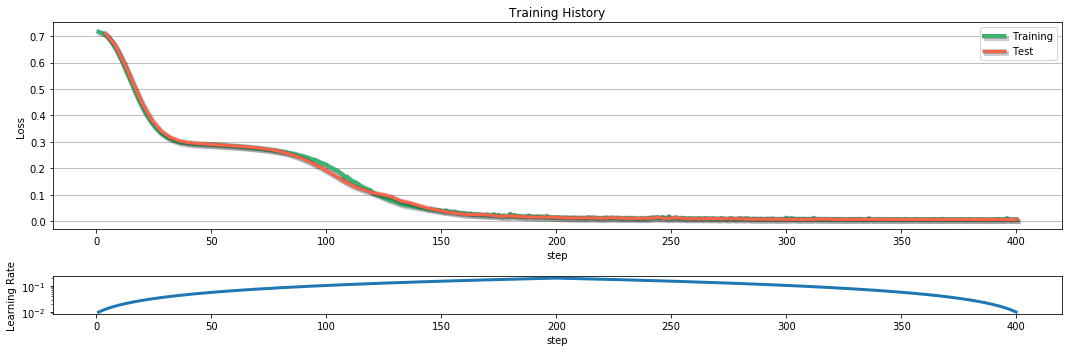

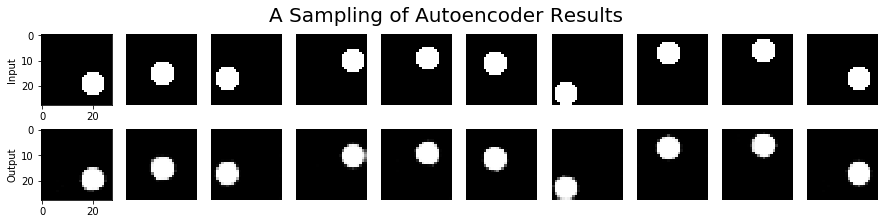

In [25]:
train_convolutional_ae(conv_channels=[4, 8, 4])

4/4 [==============================] - 0s 117ms/step - loss: 0.0051
Final Test Loss:  5.053e-03
Number of trainable parameters: 3075


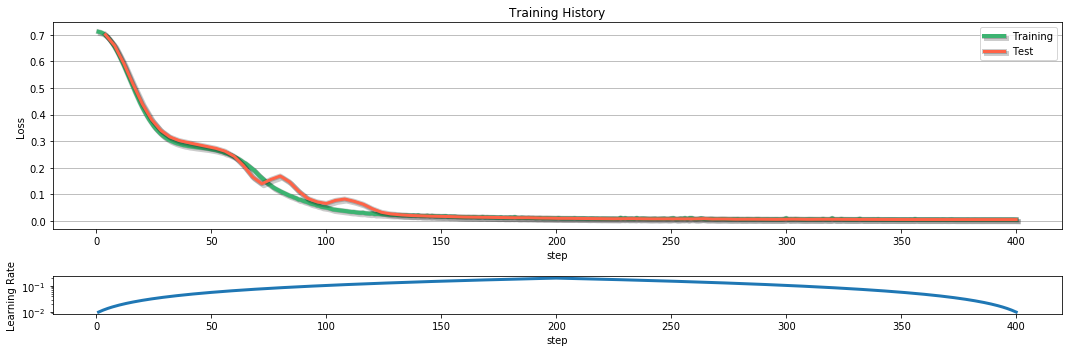

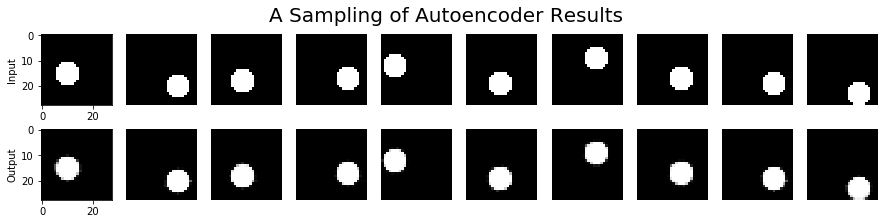

In [26]:
train_convolutional_ae(conv_channels=[4, 8, 16])